In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [3]:
# set the font size for matplotlib and the font family.
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [4]:
# load the necessary functions from the analysis package

# load the variable names, this allows to access the variables in the feature data in a compact way
from analysis_utils.variable_names import *

# load flagged ids 
from analysis_utils.flagged_uids import *

# load the functions to do spatial k-fold CV
from analysis_utils.spatial_CV import *

# load the helper functions
from analysis_utils.analysis_helpers import *

# load the random forest trainer and cross_validator
import analysis_utils.RandomForest as rf

# load the combien model
from analysis_utils.CombinedModel import CombinedModel

In [5]:
# set the global file paths
root_data_dir = "../../Data"

# the lsms data
lsms_pth = f"{root_data_dir}/lsms/processed/labels_cluster_v1.csv"

# the feature data
feat_data_pth = f"{root_data_dir}/feature_data/tabular_data.csv"

# set the random seed
random_seed = 423
spatial_cv_random_seed = 348

# set the number of folds for k-fold CV
n_folds = 5

In [6]:
# load the feature and the label data
lsms_df = pd.read_csv(lsms_pth)

# remove flagged ids form dataset
lsms_df = lsms_df[~lsms_df.unique_id.isin(flagged_uids)].reset_index(drop = True)

# create average varaibles for the between model
lsms_df['avg_log_mean_pc_cons_usd_2017'] = lsms_df.groupby('cluster_id')['log_mean_pc_cons_usd_2017'].transform('mean')
lsms_df['avg_mean_asset_index_yeh'] = lsms_df.groupby('cluster_id')['mean_asset_index_yeh'].transform('mean')

# load the feature data
feat_df = pd.read_csv(feat_data_pth)

# describe the training data broadly
print(f"Number of observations {len(lsms_df)}")
print(f"Number of clusters {len(np.unique(lsms_df.cluster_id))}")
print(f"Number of x vars {len(feat_df.columns)-2}")

Number of observations 6401
Number of clusters 2128
Number of x vars 113


In [7]:
# merge the label and the feature data to one dataset
lsms_vars = ['unique_id','n_households', 'country', 'lat', 'lon',        
             'log_mean_pc_cons_usd_2017', 'avg_log_mean_pc_cons_usd_2017',
             'mean_asset_index_yeh', 'avg_mean_asset_index_yeh']
df = pd.merge(lsms_df[lsms_vars], feat_df, on = 'unique_id', how = 'left')

In [8]:
df = pd.merge(lsms_df, feat_df, on  = ('cluster_id', 'unique_id'), how = 'left')

In [9]:
# define the x variables and the target variable for the between and within models

# define the between variables
avg_rs_vars = avg_ndvi_vars + avg_ndwi_gao_vars + avg_nl_vars
osm_vars = osm_dist_vars + osm_count_vars + osm_road_vars
between_x_vars = osm_vars + esa_lc_vars + wsf_vars + avg_rs_vars + avg_preciptiation + median_rgb_vars 
between_target_var = 'avg_log_mean_pc_cons_usd_2017'

# define the within varaibles
dyn_rs_vars = dyn_ndvi_vars + dyn_ndwi_gao_vars + dyn_nl_vars
within_x_vars = dyn_rs_vars + precipitation + dyn_rgb_vars
within_target_var = 'log_mean_pc_cons_usd_2017'

In [10]:
# define the within df for this task, including all necessary variables
within_df = df[['unique_id', 'cluster_id', within_target_var, 'rural'] + within_x_vars]

# run CV - Urban - Rural

In [10]:
within_df.rural.value_counts()

rural
1    4417
0    1984
Name: count, dtype: int64

In [11]:
# run the training and valdiation
cond = {'urban': 0, 'rural': 1}

rurb_n = {}
rurb_within_r2 = {}
rurb_predictions = {}

for loc, val in cond.items():
    print("="*100)
    print(f"Training on {loc} clusters only")
    print("="*100)
    print("\n")
    
    # subset the datasets to only those observations that meet the condition
    df_sub = df[df.rural == val].reset_index(drop = True)
    within_df_sub = within_df[within_df.rural == val].reset_index(drop = True )
    
    # standardise the datasets
    demeaned_df_norm = standardise_df(demean_df(within_df_sub), exclude_cols = [within_target_var])
    
    aux_r2_w = []
    aux_pred_df = demeaned_df_norm[['unique_id', within_target_var]].rename(columns = {within_target_var:'y'})

    # do 10-times repeated CV: 
    for j in range(10):
        print("."*100)
        print(f"Iteration {j}")
        print("."*100)

        seeed = spatial_cv_random_seed + val + j
        # split the data into training and validation folds
        fold_ids = split_lsms_spatial(df_sub, n_folds = n_folds, random_seed = seeed)

        # run the within training
        within_cv_trainer = rf.CrossValidator(demeaned_df_norm, 
                                              fold_ids, 
                                              within_target_var, 
                                              within_x_vars,
                                              id_var = 'unique_id',
                                              random_seed = seeed)
        within_cv_trainer.run_cv_training(min_samples_leaf = 1)
        within_res = within_cv_trainer.compute_overall_performance()

        # store results
        aux_r2_w.append(within_res['val_r2'])
        
        # get predictions for each iteration
        preds = pd.DataFrame(within_cv_trainer.predictions).rename(columns = {'y_hat': f"y_hat_{j}"}).drop(columns = 'y')
        aux_pred_df = pd.merge(aux_pred_df, preds, on = 'unique_id', how = 'left')
        
    rurb_n[loc] = len(within_df_sub)
    rurb_within_r2[loc] = aux_r2_w
    rurb_predictions[loc] = aux_pred_df
    
    print('\n\n\n')


Training on urban clusters only


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.38
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.12
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.05
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 165 seconds
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.39
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.12
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.06
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 168 seconds
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.36
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.15
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.04
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 165 seconds
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.34
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.18
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.06
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 162 seconds
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.34
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.27
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.12
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.06
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 164 seconds
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.34
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.16
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.06
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 163 seconds
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.43
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.09
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.05
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 163 seconds
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.35
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.16
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.06
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 162 seconds
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.35
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.18
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.02
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 162 seconds
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.41
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.12
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.06
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 162 seconds




Training on rural clusters only


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 372 seconds
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 376 seconds
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 375 seconds
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 371 seconds
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 370 seconds
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 369 seconds
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 365 seconds
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 370 seconds
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 369 seconds
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 369 seconds






In [12]:
rurb_results = {
    'n': rurb_n, 
    'within_r2': rurb_within_r2,
    'predictions': rurb_predictions  
}
pth = 'results/robustness/rurb.pkl'
with open(pth, 'wb') as f:
    pickle.dump(rurb_results, f)

# Run CV - pre - post - 2013

In [13]:
pre_2013_df = lsms_df[lsms_df.start_year < 2013].reset_index(drop = True)
# count occurence of every cluster
n_clusters = pre_2013_df.groupby('cluster_id').size().to_frame('N').reset_index()
pre_2013_df = pd.merge(pre_2013_df, n_clusters, on = 'cluster_id')
pre_2013_ids = [row.unique_id for idx, row in pre_2013_df.iterrows() if row.N > 1]


post_2013_df = lsms_df[lsms_df.start_year >= 2013].reset_index(drop = True)
# count occurence of every cluster
n_clusters = post_2013_df.groupby('cluster_id').size().to_frame('N').reset_index()
post_2013_df = pd.merge(post_2013_df, n_clusters, on = 'cluster_id')
post_2013_ids = [row.unique_id for idx, row in post_2013_df.iterrows() if row.N > 1]

# post_2013_ids = [row.unique_id for idx, row in lsms_df.iterrows() if row.start_year >= 2013]

In [14]:
# run the training and valdiation
pre_post_ids = {'pre': pre_2013_ids, 'post': post_2013_ids}

pre_post_n = {}
pre_post_within_r2 = {}
pre_post_predictions = {}
it = 0
for k, uids in pre_post_ids.items():
    print("="*100)
    print(f"Training on {k} periods only")
    print("="*100)
    print("\n")
    
    # subset the data to only those years with at least ... T years
    df_sub = df[df['unique_id'].isin(uids)].reset_index(drop = True)
    within_df_sub = within_df[within_df['unique_id'].isin(uids)].reset_index(drop = True)
    
    # standardise the datasets
    demeaned_df_norm = standardise_df(demean_df(within_df_sub), exclude_cols = [within_target_var])
    
    aux_r2_w = []
    aux_pred_df = demeaned_df_norm[['unique_id', within_target_var]].rename(columns = {within_target_var:'y'})

    # do 10-times repeated CV: 
    for j in range(10):
        print("."*100)
        print(f"Iteration {j}")
        print("."*100)
        
        seeed = spatial_cv_random_seed + it + j
        # split the data into training and validation folds
        fold_ids = split_lsms_spatial(df_sub, n_folds = n_folds, random_seed = seeed)

        # run the within training
        within_cv_trainer = rf.CrossValidator(demeaned_df_norm, 
                                              fold_ids, 
                                              within_target_var, 
                                              within_x_vars,
                                              id_var = 'unique_id',
                                              random_seed = seeed)
        within_cv_trainer.run_cv_training(min_samples_leaf = 1)
        within_res = within_cv_trainer.compute_overall_performance()

        # store results
        aux_r2_w.append(within_res['val_r2'])
        
        # get predictions for each iteration
        preds = pd.DataFrame(within_cv_trainer.predictions).rename(columns = {'y_hat': f"y_hat_{j}"}).drop(columns = 'y')
        aux_pred_df = pd.merge(aux_pred_df, preds, on = 'unique_id', how = 'left')
    
    pre_post_n[k] = len(within_df_sub)
    pre_post_within_r2[k] = aux_r2_w
    pre_post_predictions[k] = aux_pred_df
    it += 1
    
    print('\n\n\n')


Training on pre periods only


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 174 seconds
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 173 seconds
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 174 seconds
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 173 seconds
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 173 seconds
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.28
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.11
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 174 seconds
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.25
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 174 seconds
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 173 seconds
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 174 seconds
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.25
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 174 seconds




Training on post periods only


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 250 seconds
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 246 seconds
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 248 seconds
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.27
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 245 seconds
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 247 seconds
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 244 seconds
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.25
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 243 seconds
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 245 seconds
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 242 seconds
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 244 seconds






In [15]:
pre_post_13_results = {
    'n': pre_post_n, 
    'within_r2': pre_post_within_r2,
    'predictions': pre_post_predictions  
}
pth = 'results/robustness/pre_post.pkl'
with open(pth, 'wb') as f:
    pickle.dump(pre_post_13_results, f)

In [79]:
np.mean(pre_post_within_r2['pre'])

0.0025197923779363028

In [16]:
# pred_vars = ['y_hat_' + str(i) for i in range(2)]
# pre_post_13_results['predictions']['pre']['mean_y_hat'] = pre_post_13_results['predictions']['pre'][pred_vars].mean(axis = 1)


In [17]:
# pre_post_13_results['predictions']['post']['mean_y_hat'] = pre_post_13_results['predictions']['pre'][pred_vars].mean(axis = 1)

# At least T years of difference

In [18]:
# two years (drop uganda I and II 2010, and uganda I 2018)
# three years (drop Ethiopia I 2013 and Ethiopia II, drop Nigeria I II 2012, Tanzania I 2010, 2012, Tanzania III 2010, Uganda I 2011, 2015 Uganda II)
min_year_1_ids = {'uids': list(df.unique_id), 
                   'cids': list(df.cluster_id)}

# create sample with time differences of at least 2 years:
condition_1 = (df.country == 'uga') & (df.start_year == 2010)
condition_2 = (df.country == 'uga') & (df.series == 'long') & (df.start_year == 2018)
condition_2_years = condition_1 | condition_2
min_year_2_ids = {'uids': list(df[~condition_2_years].unique_id),
                   'cids': list(df[~condition_2_years].cluster_id)}


# create sample with time differences of at least 3 years:

# drop Ethiopia I 2013 and Ethiopia II
eth_cond = ((df.country == 'eth') & (df.start_year == 2013)) | ((df.country == 'eth') & (df.series == 'short'))

# drop Nigeria I II 2012
nga_cond = ((df.country == 'nga') & (df.start_year == 2012))

# drop Tanzania I 2010, 2012, Tanzania III 2010
tza_cond_1 = (df.country == 'tza') & (df.start_year == 2010)
tza_cond_2 = (df.country == 'tza') & (df.series == 'long') & (df.start_year == 2012)
tza_cond = tza_cond_1 | tza_cond_2

# drop Uganda I 2011, 2015 Uganda II
uga_cond_1 = (df.country == 'uga') & (df.series == 'short')
uga_cond_2 = (df.country == 'uga') & (df.start_year.isin([2010, 2011, 2015, 2018]))
uga_cond = uga_cond_1 | uga_cond_2

# combine all conditions
condition_3_years = eth_cond | nga_cond | tza_cond | uga_cond

min_year_3_ids = {'uids': list(df[~condition_3_years].unique_id),
                  'cids': list(df[~condition_3_years].cluster_id)}

In [19]:
# run the training and valdiation
min_year_ids = [min_year_2_ids, min_year_3_ids]

min_years_n = {}
min_years_within_r2 = {}
min_years_predictions = {}

for idx, ids in enumerate(min_year_ids):
    print("="*100)
    print(f"Training on at least {idx+2} years of difference between waves")
    print("="*100)
    print("\n")
    
    # subset the data to only those years with at least ... T years
    df_sub = df[df['unique_id'].isin(ids['uids'])].reset_index(drop = True)
    within_df_sub = within_df[within_df['unique_id'].isin(ids['uids'])].reset_index(drop = True)
    
    # standardise the datasets
    demeaned_df_norm = standardise_df(demean_df(within_df_sub), exclude_cols = [within_target_var])
    
    aux_r2_w = []
    aux_pred_df = demeaned_df_norm[['unique_id', within_target_var]].rename(columns = {within_target_var:'y'})

    # do 10-times repeated CV: 
    for j in range(10):
        print("."*100)
        print(f"Iteration {j}")
        print("."*100)
        
        seeed = spatial_cv_random_seed + idx + j
        # split the data into training and validation folds
        fold_ids = split_lsms_spatial(df_sub, n_folds = n_folds, random_seed = seeed)

        # run the within training
        within_cv_trainer = rf.CrossValidator(demeaned_df_norm, 
                                              fold_ids, 
                                              within_target_var, 
                                              within_x_vars,
                                              id_var = 'unique_id',
                                              random_seed = seeed)
        within_cv_trainer.run_cv_training(min_samples_leaf = 1)
        within_res = within_cv_trainer.compute_overall_performance()

        # store results
        aux_r2_w.append(within_res['val_r2'])
        
        # get predictions for each iteration
        preds = pd.DataFrame(within_cv_trainer.predictions).rename(columns = {'y_hat': f"y_hat_{j}"}).drop(columns = 'y')
        aux_pred_df = pd.merge(aux_pred_df, preds, on = 'unique_id', how = 'left')
    
    min_years_n[f"min_{idx+1}_years"] = len(within_df_sub)
    min_years_within_r2[f"min_{idx+1}_years"] = aux_r2_w
    min_years_predictions[f"min_{idx+1}_years"] = aux_pred_df
    
    print('\n\n\n')


Training on at least 2 years of difference between waves


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 535 seconds
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 530 seconds
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 535 seconds
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 535 seconds
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 531 seconds
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 538 seconds
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 555 seconds
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.25
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 575 seconds
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 538 seconds
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 538 seconds




Training on at least 3 years of difference between waves


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 313 seconds
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 314 seconds
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 313 seconds
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 312 seconds
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 313 seconds
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 312 seconds
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.25
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 314 seconds
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 310 seconds
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 313 seconds
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 314 seconds






In [36]:
min_years_results = {
    'n': min_years_n, 
    'within_r2': min_years_within_r2,
    'predictions': min_years_predictions  
}
pth = 'results/robustness/min_years.pkl'
with open(pth, 'wb') as f:
    pickle.dump(min_years_results, f)

In [38]:
min_years_predictions

{'min_1_years':                      unique_id         y   y_hat_0   y_hat_1   y_hat_2  \
 0     eth_010101088801601_2011 -0.110937  0.043666  0.027470  0.047810   
 1     eth_010101088801601_2013  0.181930 -0.027054  0.007058 -0.026691   
 2     eth_010101088801601_2015 -0.070993 -0.011888 -0.002336 -0.011216   
 3     eth_010102088801403_2011  0.146545  0.067077  0.052483  0.063448   
 4     eth_010102088801403_2013  0.072989 -0.019796 -0.005025 -0.049164   
 ...                        ...       ...       ...       ...       ...   
 5884          uga_4150009_2009 -0.217293  0.028462 -0.003474  0.028115   
 5885          uga_4150009_2011 -0.358443 -0.128221 -0.097611 -0.158674   
 5886          uga_4150009_2013  0.121821 -0.034096 -0.021491 -0.035710   
 5887          uga_4150009_2015  0.179608  0.021632  0.060576  0.036720   
 5888          uga_4150009_2019  0.274306  0.111215  0.123213  0.094857   
 
        y_hat_3   y_hat_4   y_hat_5   y_hat_6   y_hat_7   y_hat_8   y_hat_9  
 0   

# Make plot

In [11]:
pth = 'results/robustness/rurb.pkl'
with open(pth, 'rb') as f:
    rurb_results = pickle.load(f)

# take average over all predictions
pred_vars = ['y_hat_' + str(i) for i in range(10)]
rurb_results['predictions']['rural']['mean_y_hat'] = rurb_results['predictions']['rural'][pred_vars].mean(axis = 1)
rurb_results['predictions']['urban']['mean_y_hat'] = rurb_results['predictions']['urban'][pred_vars].mean(axis = 1)

r2_urban = {
    'mean': np.mean(rurb_results['within_r2']['urban']),
    'se': np.std(rurb_results['within_r2']['urban'])/np.sqrt(10)
}

r2_rural = {
    'mean': np.mean(rurb_results['within_r2']['rural']),
    'se': np.std(rurb_results['within_r2']['rural'])/np.sqrt(10)
}

In [12]:
pth = 'results/robustness/pre_post.pkl'
with open(pth, 'rb') as f:
    pre_post_results = pickle.load(f)

pred_vars = ['y_hat_' + str(i) for i in range(10)]
pre_post_results['predictions']['pre']['mean_y_hat'] = pre_post_results['predictions']['pre'][pred_vars].mean(axis = 1)
pre_post_results['predictions']['post']['mean_y_hat'] = pre_post_results['predictions']['post'][pred_vars].mean(axis = 1)

r2_pre = {
    'mean': np.mean(pre_post_results['within_r2']['pre']),
    'se': np.std(pre_post_results['within_r2']['pre'])/np.sqrt(10)
}

r2_post = {
    'mean': np.mean(pre_post_results['within_r2']['post']),
    'se': np.std(pre_post_results['within_r2']['post'])/np.sqrt(10)
}


In [13]:
# load the min years results
pth = 'results/robustness/min_years.pkl'
with open(pth, 'rb') as f:
    min_years_results = pickle.load(f)
    
pred_vars = ['y_hat_' + str(i) for i in range(10)]
min_years_results['predictions']['min_1_years']['mean_y_hat'] = min_years_results['predictions']['min_1_years'][pred_vars].mean(axis = 1)
min_years_results['predictions']['min_2_years']['mean_y_hat'] = min_years_results['predictions']['min_2_years'][pred_vars].mean(axis = 1)

r2_min_1 = {
    'mean': np.mean(min_years_results['within_r2']['min_1_years']),
    'se': np.std(min_years_results['within_r2']['min_1_years'])/np.sqrt(10)
}

r2_min_2 = {
    'mean': np.mean(min_years_results['within_r2']['min_2_years']),
    'se': np.std(min_years_results['within_r2']['min_2_years'])/np.sqrt(10)
}

In [14]:
plot_vals = [
    (pre_post_results['predictions']['pre']['y'], pre_post_results['predictions']['pre']['mean_y_hat']),
    (rurb_results['predictions']['rural']['y'], rurb_results['predictions']['rural']['mean_y_hat']),
    (min_years_results['predictions']['min_1_years']['y'], min_years_results['predictions']['min_1_years']['mean_y_hat']),
    (pre_post_results['predictions']['post']['y'], pre_post_results['predictions']['post']['mean_y_hat']),
    (rurb_results['predictions']['urban']['y'], rurb_results['predictions']['urban']['mean_y_hat']),
    (min_years_results['predictions']['min_2_years']['y'], min_years_results['predictions']['min_2_years']['mean_y_hat'])
]

In [15]:
r2_vals = [
    r2_pre,
    r2_rural,
    r2_min_1,
    r2_post, 
    r2_urban, 
    r2_min_2
]

In [16]:
N_vals = [
    pre_post_results['n']['pre'],
    rurb_results['n']['rural'],
    min_years_results['n']['min_1_years'],
    pre_post_results['n']['post'],
    rurb_results['n']['urban'],
    min_years_results['n']['min_2_years']
]

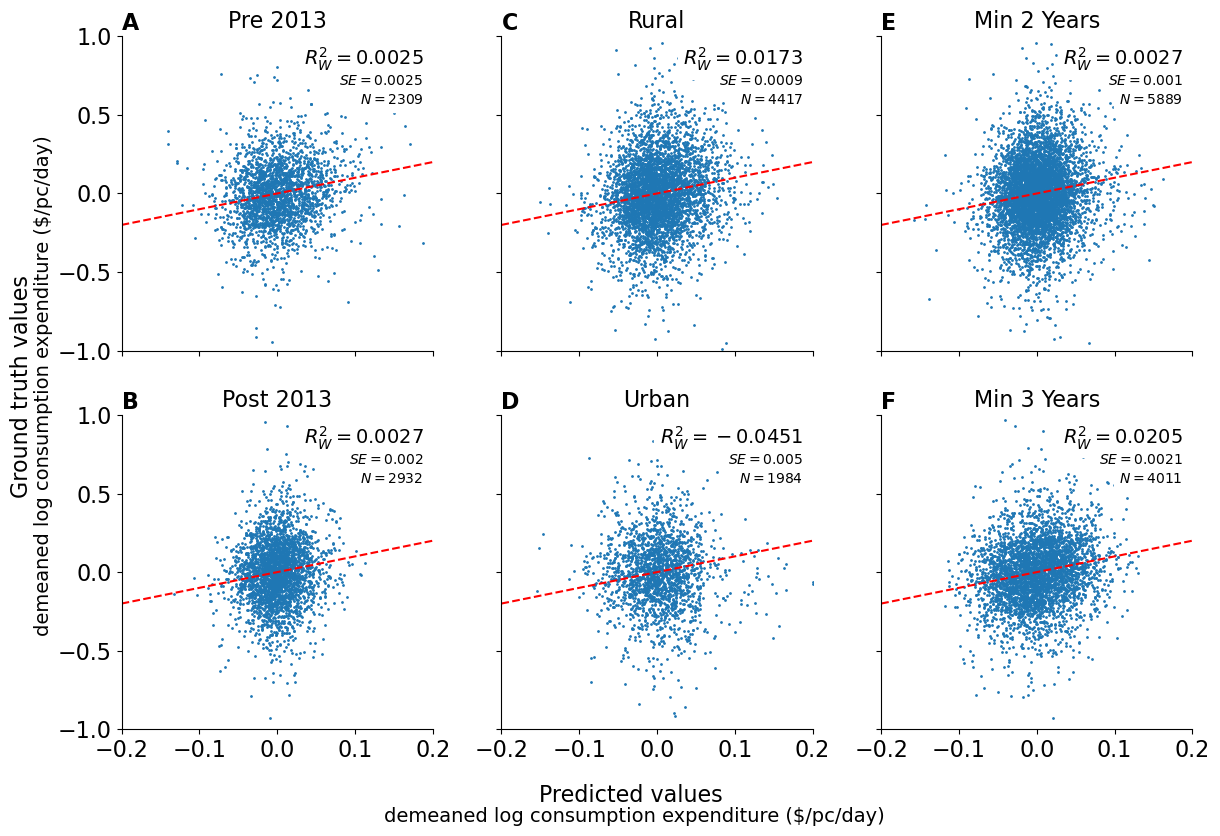

In [28]:
# make the actual plot
fig, axes = plt.subplots(2,3, figsize=(12, 8), sharex = True, sharey = True)
titles = ['Pre 2013','Rural', 'Min 2 Years', 'Post 2013','Urban', 'Min 3 Years']
letters = ['A','C','E','B','D','F']
for idx, ax in enumerate(axes.flatten()):
    vals = plot_vals[idx]
    y = vals[0]
    y_hat = vals[1]
    r2 = r2_vals[idx]
    ax.scatter(y_hat, y, s = 1)
    #ax.plot([min(y_hat), max(y_hat)], [min(y_hat), max(y_hat)], color='red', linestyle='--')  # Line of perfect correlation
    ax.plot([-.2, .2], [-.2, .2], color='red', linestyle='--')  # Line of perfect correlation

    ax.set_ylim(ymin = -1, ymax = 1)
    ax.set_xlim(xmin = -.2, xmax = .2)

    ax.set_title(titles[idx], size = 16)
    ax.spines[['right', 'top']].set_visible(False)
    
    
    # Add text in the top right corner
    text_x = 0.97  # Adjust this value for horizontal positioning
    text_y = 0.97  # Adjust this value for vertical positioning
    txt = f"$R^2_W = {np.round(r2['mean'], 4)}$"
    ax.text(text_x, text_y, txt, transform=ax.transAxes,
            fontsize=14, va='top', ha='right', backgroundcolor='white')

    text_y = 0.88
    se_txt = f"$SE = {np.round(r2['se'], 4)}$"
    ax.text(text_x, text_y, se_txt, transform=ax.transAxes,
            fontsize=10, va='top', ha='right', backgroundcolor='white')
 
    text_y = 0.82
    n_txt = f"$N = {N_vals[idx]}$"
    ax.text(text_x, text_y, n_txt, transform=ax.transAxes,
            fontsize=10, va='top', ha='right', backgroundcolor='white')
    
    text_y = 1.02
    text_x = 0
    ax.text(text_x, text_y, letters[idx], transform=ax.transAxes, weight='bold')



plt.tight_layout()

fig.text(0.5, -.02, "Predicted values ", ha="center", size = 16)
fig.text(0.5, -.045, "demeaned log consumption expenditure (\$/pc/day)", ha="center", size = 14)

fig.text(-.02, 0.5, "Ground truth values", va="center", rotation="vertical", size = 16)
fig.text(0, 0.5, "demeaned log consumption expenditure (\$/pc/day)", va="center", rotation="vertical", size = 14)

# Add spacing between subplots

plt.savefig('../figures/results/robustness_predictions.png', dpi = 300, bbox_inches = 'tight')
# Show the plot
plt.show()
